# 05차시: 데이터 시각화 - Matplotlib과 Seaborn 기초

## 학습 목표
- Matplotlib과 Seaborn 라이브러리의 기본 사용법 이해
- 선 그래프(Line Chart)로 주가 추이 시각화
- 막대 그래프(Bar Chart)로 거래량 비교
- 히스토그램(Histogram)으로 데이터 분포 분석
- Seaborn을 활용한 고급 시각화

## 사전 지식
- Python 기초 문법 (변수, 리스트)
- Pandas DataFrame 기본 사용법


---
## 1. 시각화 라이브러리 소개

### 왜 데이터 시각화가 필요한가?

금융 데이터 분석에서 시각화는 필수입니다:
- **추세 파악**: 숫자만으로는 보이지 않는 패턴을 한눈에 확인
- **이상치 발견**: 비정상적인 데이터를 시각적으로 빠르게 탐지
- **의사결정 지원**: 복잡한 데이터를 직관적으로 전달

### 주요 라이브러리

| 라이브러리 | 특징 | 용도 |
|-----------|------|------|
| Matplotlib | Python 기본 시각화 라이브러리 | 세밀한 커스터마이징 |
| Seaborn | Matplotlib 기반 고급 라이브러리 | 통계적 시각화, 미려한 디자인 |


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
✅ Korean font ready: NanumGothic
   - path: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


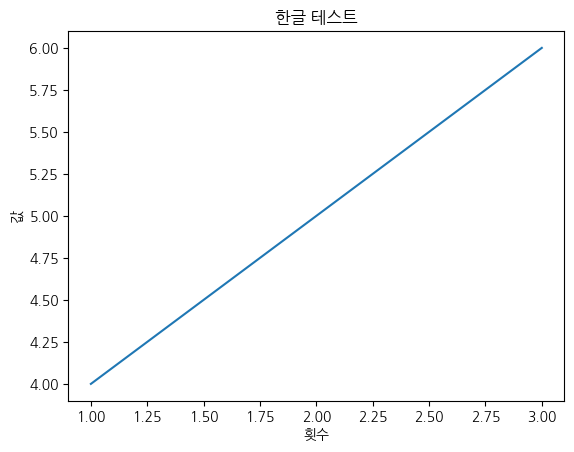

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib import gridspec
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def setup_korean_font_colab(force=False, verbose=True):
    """
    Colab + Matplotlib에서 한글이 절대 깨지지 않도록 하는 통합 함수

    - 폰트 설치 (최초 1회)
    - fontManager에 즉시 등록 (런타임 재시작 불필요)
    - rcParams 재확정 (새 Figure, 로그 스케일, legend 대응)
    - PDF 저장 시 폰트 임베딩까지 처리

    force=True  -> rcParams를 무조건 다시 설정
    """

    import os
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

    # 1) 폰트 설치 (없을 때만)
    if not os.path.exists(font_path):
        !apt-get update -qq
        !apt-get install -y fonts-nanum -qq

    # 2) Matplotlib에 폰트 등록 (중요: 재시작 불필요)
    try:
        fm.fontManager.addfont(font_path)
    except Exception:
        pass  # 이미 등록돼 있으면 무시

    # 3) 폰트 이름 확정
    font_name = fm.FontProperties(fname=font_path).get_name()

    # 4) rcParams 재확정
    mpl.rcParams["font.family"] = font_name
    mpl.rcParams["axes.unicode_minus"] = False
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42

    if verbose:
        print(f"✅ Korean font ready: {font_name}")
        print(f"   - path: {font_path}")

    return font_name

setup_korean_font_colab()

#테스트
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 테스트')
plt.xlabel('횟수')
plt.ylabel('값')
plt.show()

In [2]:
import numpy as np
import pandas as pd

# 실습용 가상 주가 데이터 생성
np.random.seed(42)

# 50일간의 가상 주가 데이터
dates = pd.date_range('2024-01-01', periods=50, freq='B')  # 영업일 기준
base_price = 70000  # 삼성전자 수준 기준가
price_changes = np.random.randn(50) * 800  # 일일 변동
prices = base_price + np.cumsum(price_changes)

df = pd.DataFrame({
    '날짜': dates,
    '시가': (prices + np.random.randn(50) * 200).astype(int),
    '고가': (prices + abs(np.random.randn(50) * 500)).astype(int),
    '저가': (prices - abs(np.random.randn(50) * 500)).astype(int),
    '종가': prices.astype(int),
    '거래량': np.random.randint(10_000_000, 30_000_000, 50)
})

# 고가/저가 논리적 정합성 보정
df['고가'] = df[['고가', '종가', '시가']].max(axis=1)
df['저가'] = df[['저가', '종가', '시가']].min(axis=1)

print("가상 주가 데이터 생성 완료!")
print(f"기간: {df['날짜'].iloc[0].strftime('%Y-%m-%d')} ~ {df['날짜'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"데이터 수: {len(df)}개")
print("\n처음 5개 데이터:")
df.head()

가상 주가 데이터 생성 완료!
기간: 2024-01-01 ~ 2024-03-08
데이터 수: 50개

처음 5개 데이터:


,날짜,시가,고가,저가,종가,거래량
0,2024-01-01,70462,71105,70272,70397,20192257
1,2024-01-02,70209,70497,70113,70286,19613273
2,2024-01-03,70669,70976,70464,70804,17315360
3,2024-01-04,72145,72424,71907,72023,26358792
4,2024-01-05,72042,72042,71689,71836,10498863


---
## 2. Matplotlib 기초: 선 그래프 (Line Chart)

### 선 그래프란?
- 시간에 따른 데이터 변화를 표현하는 가장 기본적인 차트
- 주가, 환율 등 시계열 데이터 시각화에 필수

### 기본 문법
```python
plt.plot(x, y)           # 기본 선 그래프
plt.xlabel('X축 레이블')  # X축 이름
plt.ylabel('Y축 레이블')  # Y축 이름
plt.title('차트 제목')    # 제목
plt.show()               # 차트 표시
```


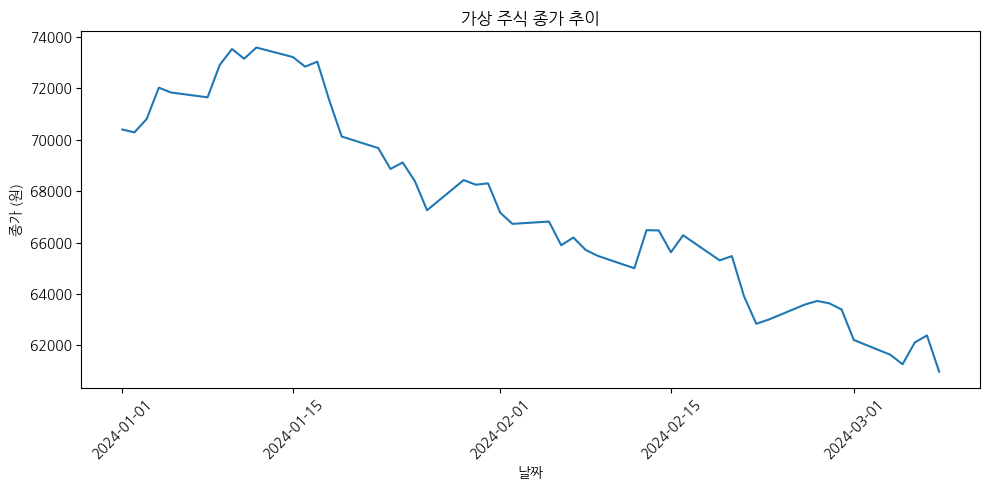

[결과] 50일간의 주가 변동 추이를 확인할 수 있습니다.


In [3]:
# 실습 2-1: 기본 선 그래프 - 종가 추이

plt.figure(figsize=(10, 5))  # 그래프 크기 설정

plt.plot(df['날짜'], df['종가'])

plt.title('가상 주식 종가 추이')
plt.xlabel('날짜')
plt.ylabel('종가 (원)')

plt.xticks(rotation=45)  # X축 레이블 45도 회전
plt.tight_layout()       # 레이아웃 자동 조정
plt.show()

print("[결과] 50일간의 주가 변동 추이를 확인할 수 있습니다.")

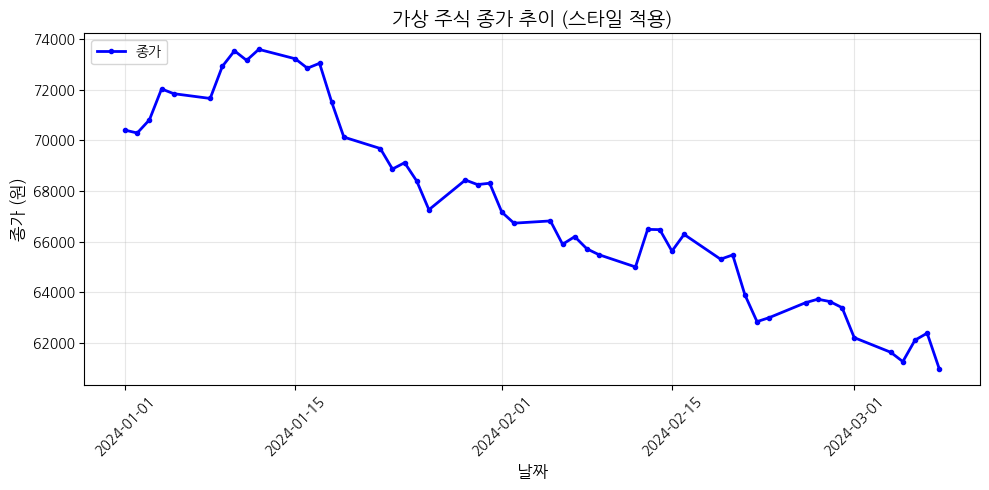

[팁] color, linewidth, marker 등을 조합해 다양한 스타일을 만들 수 있습니다.


In [4]:
# 실습 2-2: 스타일 적용 선 그래프

plt.figure(figsize=(10, 5))

# 선 스타일 옵션: color(색상), linewidth(두께), linestyle(선 종류), marker(마커)
plt.plot(df['날짜'], df['종가'],
         color='blue',        # 선 색상
         linewidth=2,         # 선 두께
         linestyle='-',       # 실선 ('-', '--', ':', '-.')
         marker='o',          # 마커 모양 ('o', 's', '^', 'D')
         markersize=3,        # 마커 크기
         label='종가')        # 범례 이름

plt.title('가상 주식 종가 추이 (스타일 적용)', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('종가 (원)', fontsize=12)
plt.legend(loc='upper left')  # 범례 위치
plt.grid(True, alpha=0.3)     # 격자선 표시

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("[팁] color, linewidth, marker 등을 조합해 다양한 스타일을 만들 수 있습니다.")

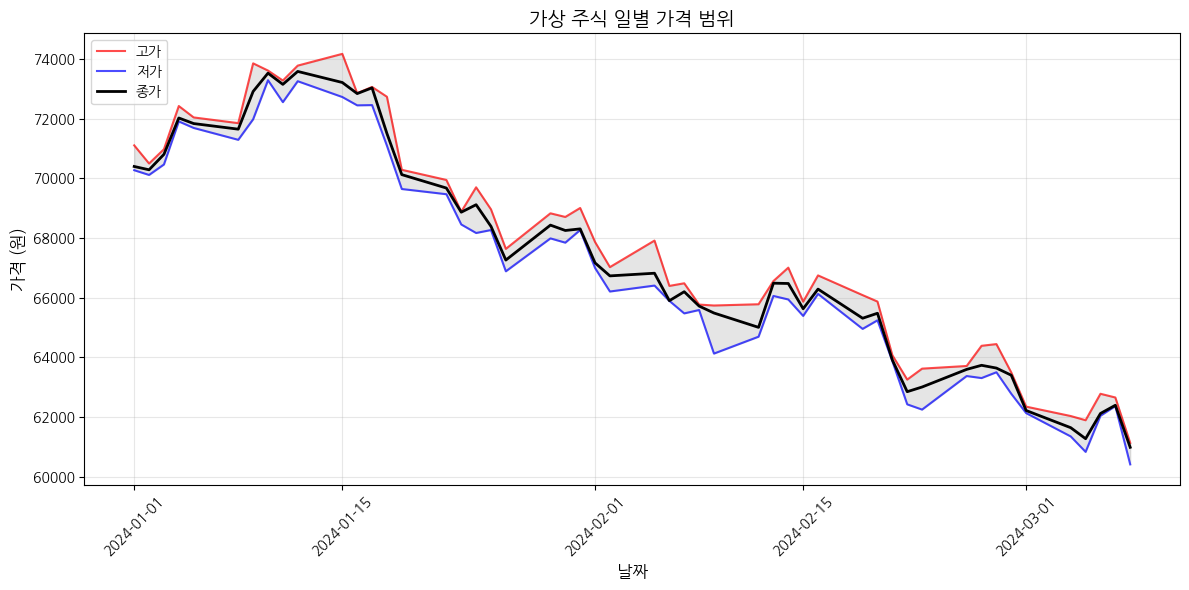

[결과] 고가-저가 범위와 종가의 관계를 한눈에 파악할 수 있습니다.


In [5]:
# 실습 2-3: 여러 선 그래프 한번에 그리기 (고가, 저가, 종가 비교)

plt.figure(figsize=(12, 6))

plt.plot(df['날짜'], df['고가'], color='red', linewidth=1.5, label='고가', alpha=0.7)
plt.plot(df['날짜'], df['저가'], color='blue', linewidth=1.5, label='저가', alpha=0.7)
plt.plot(df['날짜'], df['종가'], color='black', linewidth=2, label='종가')

# 고가-저가 사이 영역 채우기
plt.fill_between(df['날짜'], df['고가'], df['저가'], alpha=0.2, color='gray')

plt.title('가상 주식 일별 가격 범위', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('가격 (원)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("[결과] 고가-저가 범위와 종가의 관계를 한눈에 파악할 수 있습니다.")

---
## 3. Matplotlib 기초: 막대 그래프 (Bar Chart)

### 막대 그래프란?
- 항목별 값의 크기를 비교하는 차트
- 거래량, 종목별 수익률 비교 등에 활용

### 기본 문법
```python
plt.bar(x, height)          # 세로 막대 그래프
plt.barh(y, width)          # 가로 막대 그래프
```


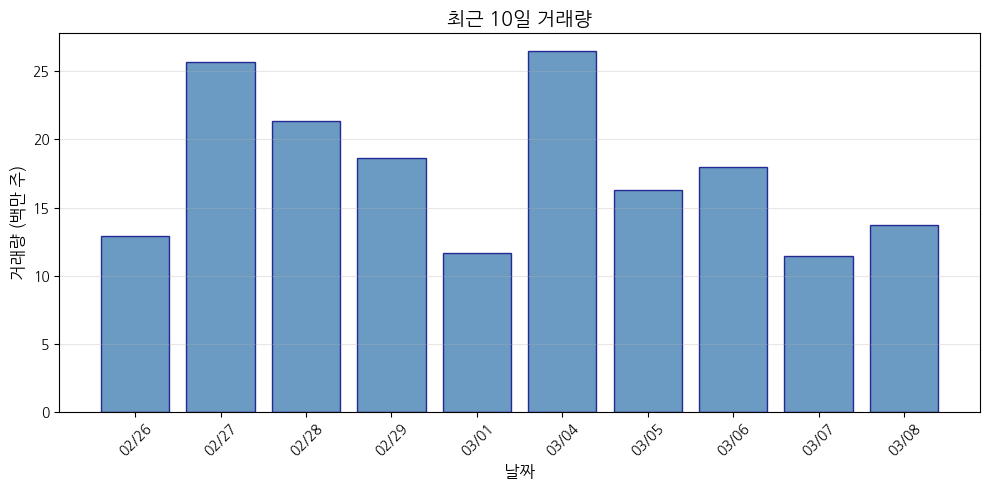

[결과] 일별 거래량의 상대적 크기를 비교할 수 있습니다.


In [6]:
# 실습 3-1: 최근 10일 거래량 막대 그래프

recent_10 = df.tail(10).copy()

plt.figure(figsize=(10, 5))

# 막대 그래프 생성
bars = plt.bar(recent_10['날짜'].dt.strftime('%m/%d'),
               recent_10['거래량'] / 1_000_000,  # 백만 단위로 변환
               color='steelblue',
               edgecolor='navy',
               alpha=0.8)

plt.title('최근 10일 거래량', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('거래량 (백만 주)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)  # Y축 격자선만 표시

plt.tight_layout()
plt.show()

print("[결과] 일별 거래량의 상대적 크기를 비교할 수 있습니다.")

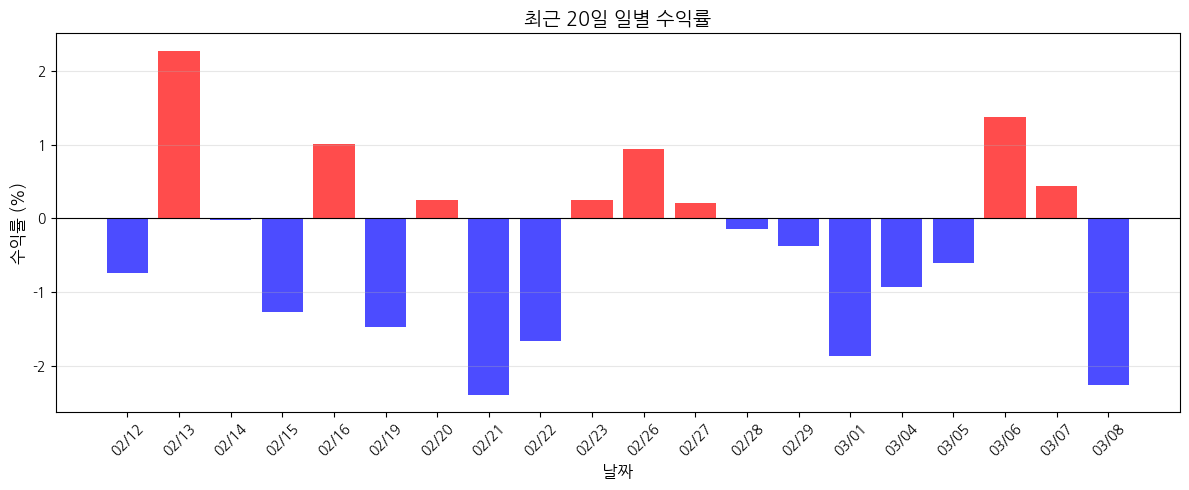

[참고] 빨간색: 상승, 파란색: 하락
평균 수익률: -0.35%


In [7]:
# 실습 3-2: 일별 수익률 막대 그래프 (상승/하락 색상 구분)

# 일별 수익률 계산
df['수익률'] = df['종가'].pct_change() * 100  # 퍼센트로 변환
recent_20 = df.tail(20).copy()

plt.figure(figsize=(12, 5))

# 상승(양수)은 빨간색, 하락(음수)은 파란색
colors = ['red' if x >= 0 else 'blue' for x in recent_20['수익률']]

plt.bar(recent_20['날짜'].dt.strftime('%m/%d'),
        recent_20['수익률'],
        color=colors,
        alpha=0.7)

# 기준선 (0%)
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='-')

plt.title('최근 20일 일별 수익률', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('수익률 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("[참고] 빨간색: 상승, 파란색: 하락")
print(f"평균 수익률: {recent_20['수익률'].mean():.2f}%")

---
## 4. Matplotlib 기초: 히스토그램 (Histogram)

### 히스토그램이란?
- 데이터의 분포를 시각화하는 차트
- 값의 빈도(frequency)를 구간별로 표시
- 주가 수익률 분포, 거래량 분포 분석에 활용

### 막대 그래프 vs 히스토그램
| 구분 | 막대 그래프 | 히스토그램 |
|------|-----------|-----------|
| 용도 | 항목별 비교 | 분포 표현 |
| X축 | 범주형 (날짜, 종목명) | 연속형 (가격, 수익률) |
| 막대 간격 | 있음 | 없음 (연속) |

### 기본 문법
```python
plt.hist(data, bins=20)   # bins: 구간 개수
```


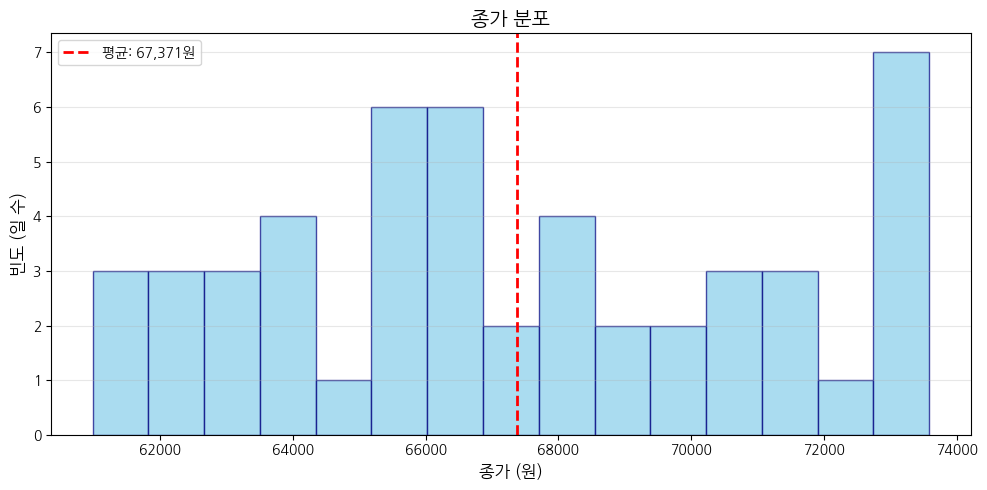

[통계] 최소: 60,981원, 최대: 73,584원, 평균: 67,371원


In [8]:
# 실습 4-1: 종가 분포 히스토그램

plt.figure(figsize=(10, 5))

plt.hist(df['종가'],
         bins=15,              # 15개 구간으로 나눔
         color='skyblue',
         edgecolor='navy',
         alpha=0.7)

# 평균선 표시
mean_price = df['종가'].mean()
plt.axvline(x=mean_price, color='red', linewidth=2, linestyle='--', label=f'평균: {mean_price:,.0f}원')

plt.title('종가 분포', fontsize=14, fontweight='bold')
plt.xlabel('종가 (원)', fontsize=12)
plt.ylabel('빈도 (일 수)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"[통계] 최소: {df['종가'].min():,}원, 최대: {df['종가'].max():,}원, 평균: {mean_price:,.0f}원")

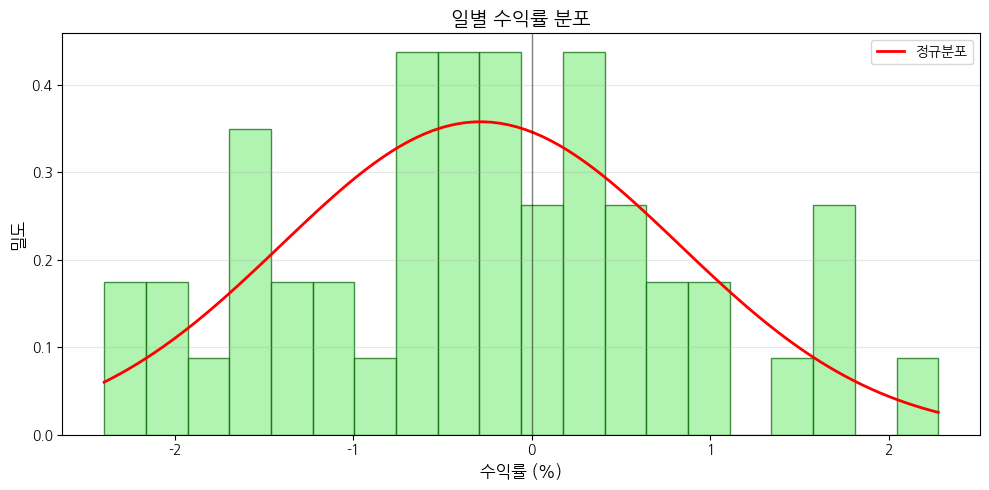

[통계] 평균 수익률: -0.29%, 표준편차: 1.12%


In [9]:
# 실습 4-2: 일별 수익률 분포 히스토그램

# 결측치 제거 (첫 번째 행)
returns = df['수익률'].dropna()

plt.figure(figsize=(10, 5))

# 히스토그램 + 밀도 곡선
n, bins, patches = plt.hist(returns,
                             bins=20,
                             color='lightgreen',
                             edgecolor='darkgreen',
                             alpha=0.7,
                             density=True)  # 밀도로 정규화

# 정규분포 곡선 추가
from scipy import stats
x = np.linspace(returns.min(), returns.max(), 100)
plt.plot(x, stats.norm.pdf(x, returns.mean(), returns.std()),
         color='red', linewidth=2, label='정규분포')

# 0% 기준선
plt.axvline(x=0, color='black', linewidth=1, linestyle='-', alpha=0.5)

plt.title('일별 수익률 분포', fontsize=14, fontweight='bold')
plt.xlabel('수익률 (%)', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"[통계] 평균 수익률: {returns.mean():.2f}%, 표준편차: {returns.std():.2f}%")

---
## 5. Seaborn 기초

### Seaborn의 특징
- Matplotlib을 기반으로 더 아름다운 시각화 제공
- 통계적 시각화에 특화
- 간단한 코드로 복잡한 차트 생성 가능

### 주요 차트 종류
| 함수 | 용도 | 예시 |
|-----|------|------|
| `sns.lineplot()` | 선 그래프 | 시계열 추이 |
| `sns.barplot()` | 막대 그래프 | 항목별 비교 |
| `sns.histplot()` | 히스토그램 | 분포 분석 |
| `sns.heatmap()` | 히트맵 | 상관관계 시각화 |
| `sns.boxplot()` | 박스플롯 | 이상치 탐지 |


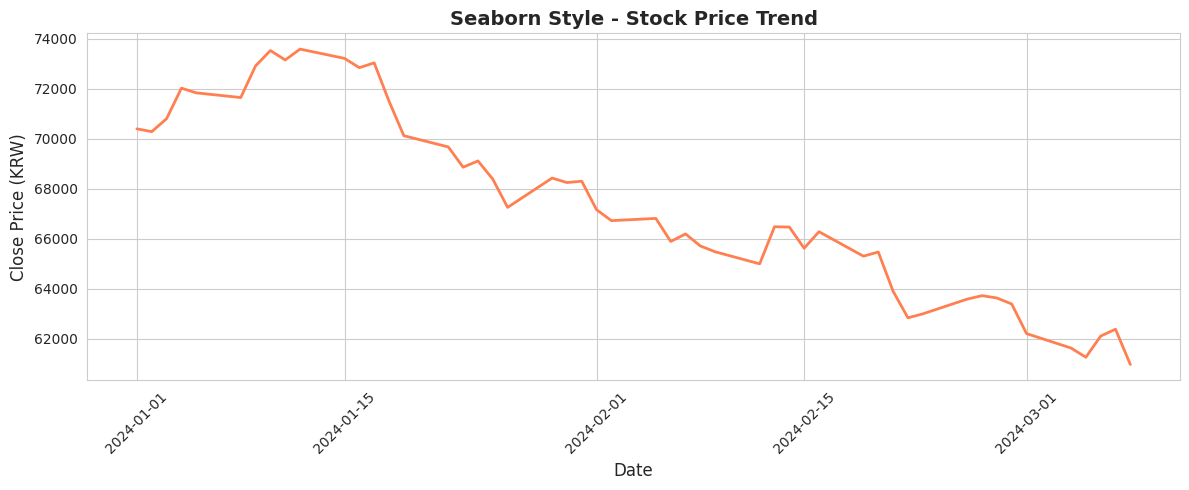

[비교] Matplotlib 기본 스타일보다 더 세련된 디자인을 제공합니다.
[참고] Seaborn은 Colab에서 한글 폰트 이슈가 있어 영문으로 표시합니다.


In [10]:
import seaborn as sns

# 실습 5-1: Seaborn 스타일 설정 및 선 그래프

# Seaborn 스타일 적용
sns.set_style('whitegrid')  # 스타일: white, dark, whitegrid, darkgrid, ticks
sns.set_palette('Set2')      # 색상 팔레트 설정

plt.figure(figsize=(12, 5))

# Seaborn 선 그래프 (Colab 한글 폰트 이슈로 영문 사용)
sns.lineplot(data=df, x='날짜', y='종가', linewidth=2, color='coral')

plt.title('Seaborn Style - Stock Price Trend', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (KRW)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("[비교] Matplotlib 기본 스타일보다 더 세련된 디자인을 제공합니다.")
print("[참고] Seaborn은 Colab에서 한글 폰트 이슈가 있어 영문으로 표시합니다.")

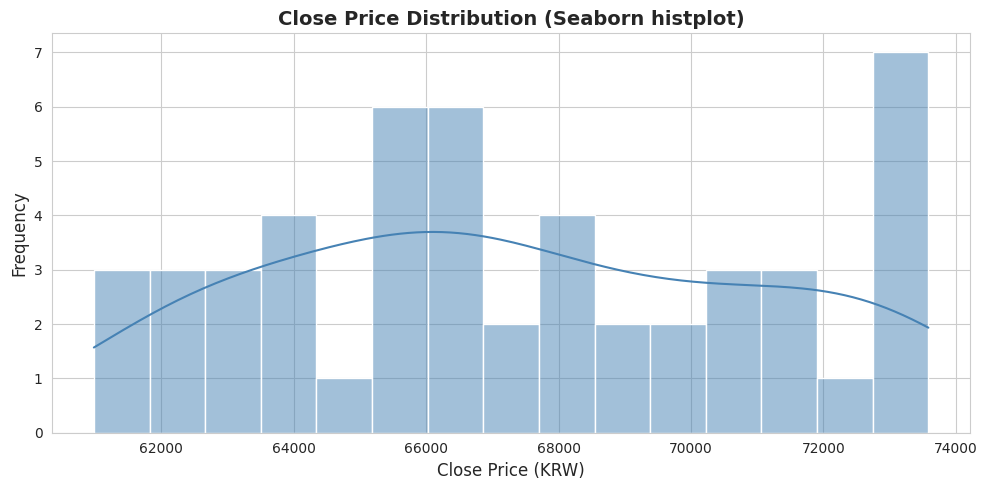

[팁] kde=True 옵션으로 분포 곡선을 자동으로 추가할 수 있습니다.


In [11]:
# 실습 5-2: Seaborn 히스토그램 + KDE (커널 밀도 추정)

plt.figure(figsize=(10, 5))

# histplot: 히스토그램 + KDE 곡선을 한번에 (Colab 한글 폰트 이슈로 영문 사용)
sns.histplot(df['종가'],
             bins=15,
             kde=True,           # KDE 곡선 추가
             color='steelblue',
             edgecolor='white')

plt.title('Close Price Distribution (Seaborn histplot)', fontsize=14, fontweight='bold')
plt.xlabel('Close Price (KRW)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

print("[팁] kde=True 옵션으로 분포 곡선을 자동으로 추가할 수 있습니다.")

/tmp/ipython-input-2184222199.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=price_data, x='Price Type', y='Price', palette='Set3')


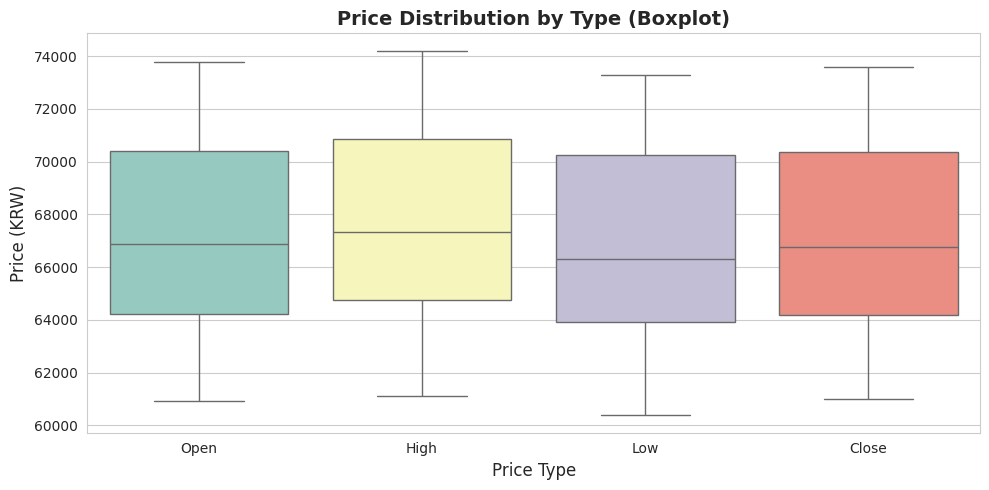

[해석] 박스: 25%~75% 범위, 가운데 선: 중앙값, 점: 이상치


In [12]:
# 실습 5-3: 박스플롯 (Boxplot) - 이상치 시각화

# 가격 데이터를 긴 형식으로 변환 (Colab 한글 폰트 이슈로 영문 컬럼명 사용)
price_data_en = df[['시가', '고가', '저가', '종가']].copy()
price_data_en.columns = ['Open', 'High', 'Low', 'Close']
price_data = price_data_en.melt(var_name='Price Type', value_name='Price')

plt.figure(figsize=(10, 5))

# 박스플롯: 사분위수와 이상치를 한눈에 확인
sns.boxplot(data=price_data, x='Price Type', y='Price', palette='Set3')

plt.title('Price Distribution by Type (Boxplot)', fontsize=14, fontweight='bold')
plt.xlabel('Price Type', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)

plt.tight_layout()
plt.show()

print("[해석] 박스: 25%~75% 범위, 가운데 선: 중앙값, 점: 이상치")

---
## 6. 차트 저장하기

생성한 차트를 이미지 파일로 저장할 수 있습니다.


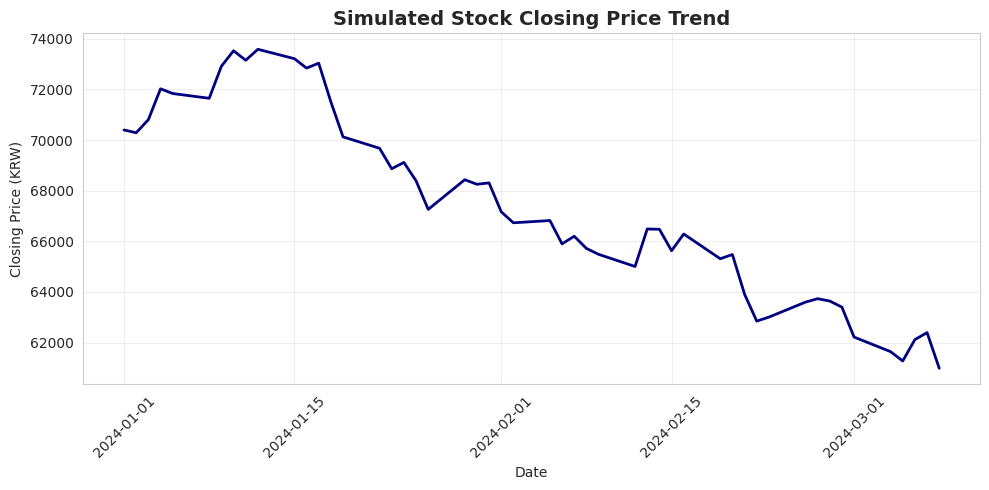

[저장 완료] 파일이 생성되었습니다:
  - stock_chart.png (이미지)
  - stock_chart.pdf (벡터)

[팁] dpi=150: 해상도 설정, bbox_inches='tight': 여백 자동 조정


In [13]:
# 실습 6-1: 차트 이미지 파일로 저장

plt.figure(figsize=(10, 5))
plt.plot(df['날짜'], df['종가'], color='navy', linewidth=2)

plt.title('Simulated Stock Closing Price Trend', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Closing Price (KRW)')

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save files (must be called before show())
plt.savefig('stock_chart.png', dpi=150, bbox_inches='tight')  # PNG format
plt.savefig('stock_chart.pdf', bbox_inches='tight')          # PDF format

plt.show()

print("[저장 완료] 파일이 생성되었습니다:")
print("  - stock_chart.png (이미지)")
print("  - stock_chart.pdf (벡터)")
print("\n[팁] dpi=150: 해상도 설정, bbox_inches='tight': 여백 자동 조정")

---
## 8. 학습 정리

### 오늘 배운 내용

| 차트 종류 | 함수 | 용도 |
|----------|------|------|
| 선 그래프 | `plt.plot()` / `sns.lineplot()` | 시계열 추이 |
| 막대 그래프 | `plt.bar()` / `sns.barplot()` | 항목별 비교 |
| 히스토그램 | `plt.hist()` / `sns.histplot()` | 분포 분석 |
| 박스플롯 | `sns.boxplot()` | 이상치 탐지 |
| 히트맵 | `sns.heatmap()` | 상관관계 |

### 핵심 포인트
1. **Matplotlib**: 기본적이고 세밀한 커스터마이징 가능
2. **Seaborn**: 더 아름답고 통계적 시각화에 적합
3. **서브플롯**: 여러 차트를 조합하여 대시보드 구성
4. **저장**: `plt.savefig()`로 이미지/PDF 저장




---
## 연습 문제

아래 코드를 완성하여 다음 조건을 만족하는 차트를 그려보세요:

1. 고가와 저가의 차이(일중 변동폭)를 계산
2. 일중 변동폭의 히스토그램 그리기
3. 평균 변동폭을 빨간 점선으로 표시
